# Анализ данных и проверка гипотез для сервиса аренды самокатов GoFast

Популярному сервису аренды самокатов GoFast требуется проанализировать данные из мобильного приложения о некоторых пользователях из нескольких городов, а также об их поездках. Помимо анализа необходимо проверить некоторые гипотезы, которые могут помочь бизнесу вырасти. Основные две рассматриваемые группы: пользователи с подпиской и без неё.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st
from math import sqrt

### Загрузка данных

Загрузим данные о пользователях:

In [2]:
df_users = pd.read_csv('datasets/users_go.csv')
df_users.info()
df_users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
...,...,...,...,...,...
1560,829,Федор,29,Пятигорск,free
1561,809,Юрий,26,Сочи,free
1562,307,Ясмина,19,Краснодар,ultra
1563,47,Юрий,28,Тюмень,ultra


Загрузим данные о поездках:

In [3]:
df_rides = pd.read_csv('datasets/rides_go.csv')
df_rides.info()
df_rides

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04
18064,1534,2840.423057,21.409799,2021-11-16
18065,1534,3826.185507,18.435051,2021-11-18
18066,1534,2902.308661,16.674362,2021-11-27


Загрузим данные о подписках:

In [4]:
df_subs = pd.read_csv('datasets/subscriptions_go.csv')
df_subs.info()
df_subs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Вывод:** По общим данным сразу заметно, что отсутствующих значений ни в одном датасете нет. Названия и типы данных корректны, за исключением столбца date. Размеры датасетов 1565, 18068 и 2.

### Предобработка данных

Приведём столбец date к типу datetime и создадим отдельный столбец с месяцем. Также убедимся, что данные представлены за все месяцы 2021 года:

In [5]:
df_rides['date'] = pd.to_datetime(df_rides['date'], format='%Y-%m-%d')
df_rides['month'] = df_rides['date'].dt.month
sorted(df_rides['month'].unique()), *sorted(df_rides['date'].dt.year.unique())

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 2021)

Проверим наличие явных дубликатов в наборе данных о пользователях:

In [6]:
df_users.duplicated().sum()

31

Найден 31 дубликат. Удалим их и убедимся, что нет и разных данных для повторяющихся пользователей:

In [7]:
df_users.drop_duplicates(inplace=True)
df_users['user_id'].duplicated().sum()

0

Аналогично проверим, что в датасетах с поездками и подписками явных дубликатов нет:

In [8]:
df_rides.duplicated().sum()+df_subs.duplicated().sum()

0

Оснований для подозрения неявных дубликатов также не имеется.

**Вывод:** Теперь все столбцы имеют нужный тип, дубликаты устранены. Размер датасета с пользователями сократился на 31 до 1534.

### Исследовательский анализ данных

В данном разделе опишем и визуализируем общую информацию о пользователях и поездках.

#### Частота встречаемости городов

Как видно, данные о пользователях распределены примерно поровну (от 11% до 14.3%) по 8 крупным городам:

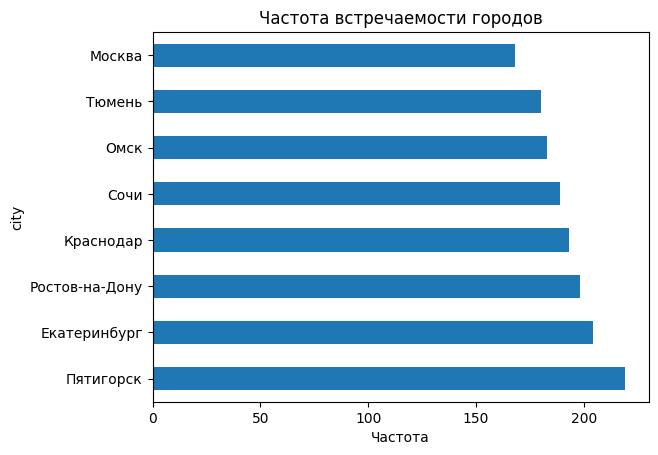

city
Пятигорск         14.3
Екатеринбург      13.3
Ростов-на-Дону    12.9
Краснодар         12.6
Сочи              12.3
Омск              11.9
Тюмень            11.7
Москва            11.0
Name: count, dtype: float64

In [9]:
df_users['city'].value_counts().plot(kind='barh')
plt.title('Частота встречаемости городов')
plt.xlabel('Частота')
plt.show()
round(df_users['city'].value_counts()/len(df_users), 3)*100

#### Соотношение пользователей с подпиской и без подписки

Можем наблюдать, что пользователей без подписки чуть больше (54.4% против 45.6%):

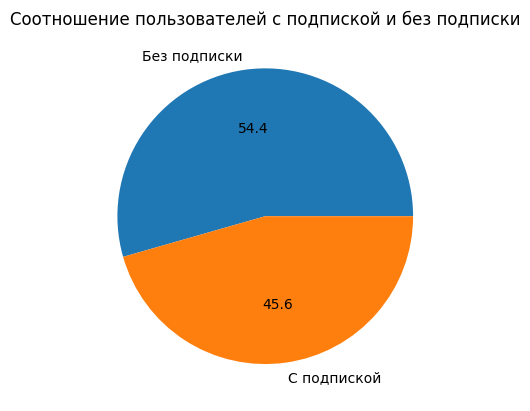

subscription_type
free     0.544329
ultra    0.455671
Name: count, dtype: float64

In [10]:
df_users['subscription_type'].value_counts().plot(kind='pie', autopct='%.1f', labels=['Без подписки', 'С подпиской'])
plt.ylabel('')
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.show()
df_users['subscription_type'].value_counts()/len(df_users)

#### Возраст пользователей

Возраст распределён между 12 и 43 годами, среднее и медиана находятся в районе 25, а само распределение очень похоже на нормальное:

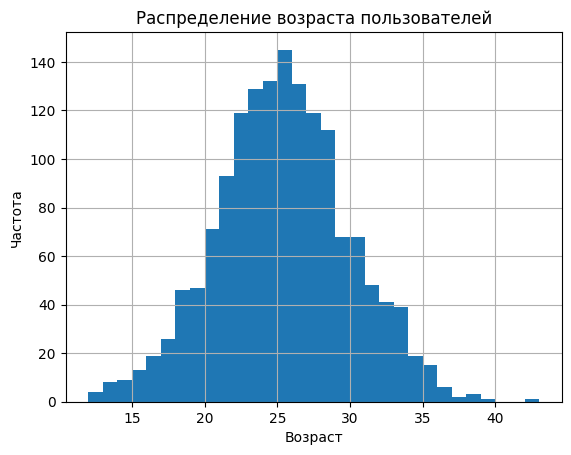

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

In [11]:
df_users['age'].hist(bins=df_users['age'].max()-df_users['age'].min())
plt.title('Распределение возраста пользователей')
plt.ylabel('Частота')
plt.xlabel('Возраст')
plt.show()
df_users['age'].describe()

#### Расстояние, которое пользователь преодолел за одну поездку

Расстояние распределено между 1 и 7211 метрами со средним 3070 и медианой 3130 метров. Распределение не совсем похоже на нормальное, спуск слева более резкий, но включает в себя необъяснимый малый пик в районе 500 метров. Распределение внутри значений до 1000 метров в целом похоже на распределение остальных поездок и по городам, и по возрасту пользователей. Однако средняя в скорость в 65 м/мин (3.9 км/ч) почти в 3 раза ниже обычной и скорее напоминает скорость пешехода, что странно.

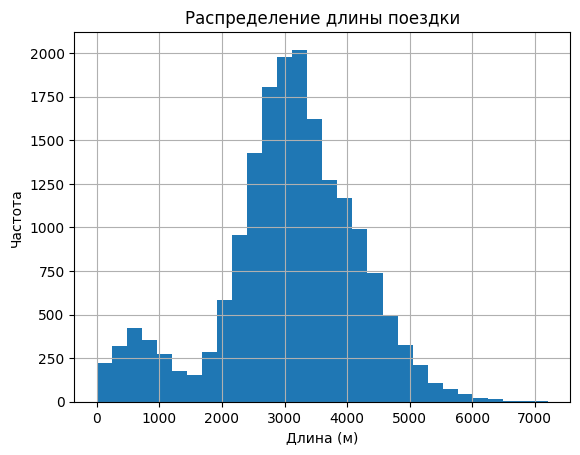

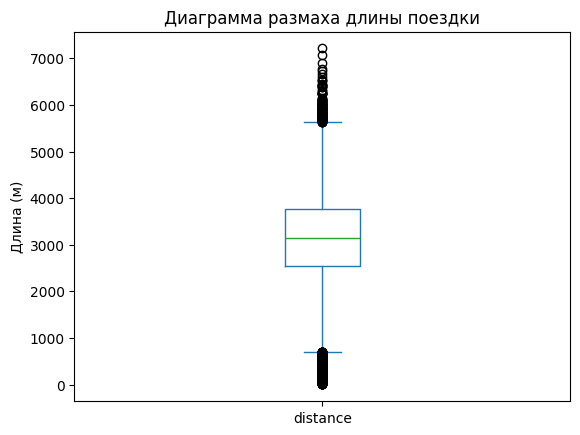

count    1372.000000
mean        9.555959
std         3.823324
min         2.035632
25%         6.397153
50%         9.336174
75%        12.832299
max        18.235650
Name: duration, dtype: float64


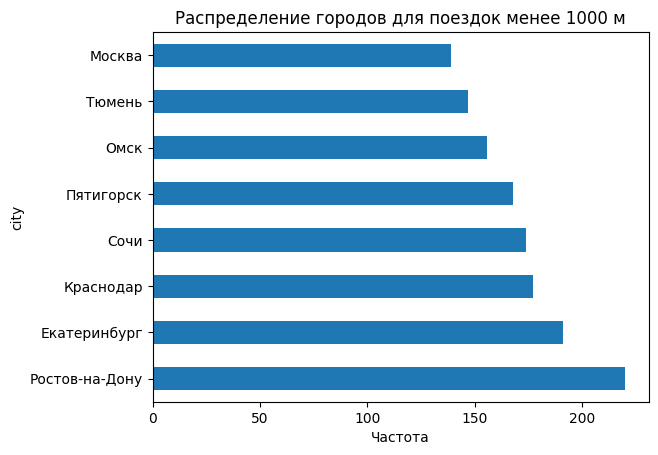

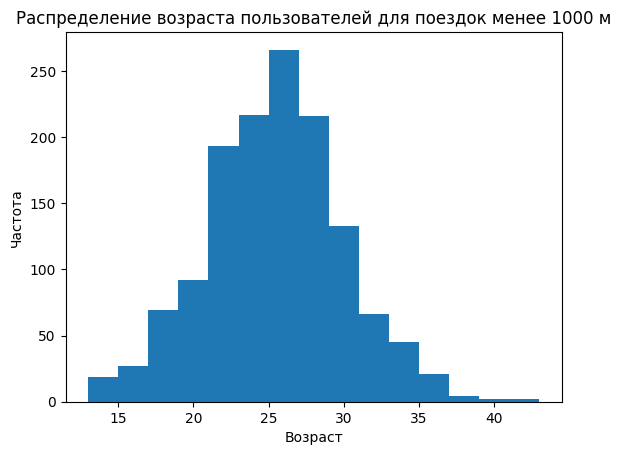

,Меньше 1000,Больше 1000
count,1372.000000,16696.000000
mean,65.672668,243.237826
std,40.463491,763.925887
min,0.085552,53.374821
25%,36.493285,143.366727
50%,58.147141,176.316062
75%,87.980042,220.057071
max,232.035937,14422.015489


In [12]:
df_rides['distance'].hist(bins=30)
plt.title('Распределение длины поездки')
plt.xlabel('Длина (м)')
plt.ylabel('Частота')
plt.show()
df_rides['distance'].plot(kind='box')
plt.title('Диаграмма размаха длины поездки')
plt.xlabel('')
plt.ylabel('Длина (м)')
plt.show()

df_less = df_rides[df_rides['distance']<1000]
print(df_less['duration'].describe())
df_less.merge(df_users, on='user_id')['city'].value_counts().plot(kind='barh')
plt.title('Распределение городов для поездок менее 1000 м')
plt.xlabel('Частота')
plt.show()
df_less.merge(df_users, on='user_id')['age'].plot(kind='hist', bins=15)
plt.title('Распределение возраста пользователей для поездок менее 1000 м')
plt.ylabel('Частота')
plt.xlabel('Возраст')
plt.show()
df_more = df_rides[df_rides['distance']>1000]
pd.concat([(df_less['distance']/df_less['duration']).describe().rename('Меньше 1000'), (df_more['distance']/df_more['duration']).describe().rename('Больше 1000')], axis=1)

#### Продолжительность поездок

Построим распределение продолжительности поездок. Можно заметить небольшой пик возле нуля. При ближайшем рассмотрении оказывается, что он состоит из 95 поездок длиной ровной 0.5 минут и с расстоянием 4000-7200 метров, что кажется невозможным. При этом сами поездки совершены разными пользователями в разное время:

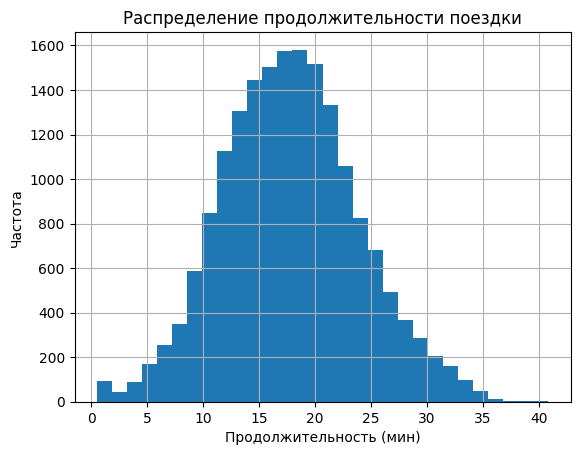

[0.5] 95
count      95.000000
mean     5113.176549
std       658.254104
min      4030.308008
25%      4611.510820
50%      5052.769411
75%      5488.459099
max      7211.007745
Name: distance, dtype: float64


,user_id,distance,duration,date,month
0,701,4196.445201,0.5,2021-08-31,8
1,704,4830.824371,0.5,2021-10-14,10
2,712,4684.004397,0.5,2021-03-04,3
3,713,5215.642710,0.5,2021-02-25,2
4,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
90,1460,5531.335845,0.5,2021-01-19,1
91,1477,6724.932981,0.5,2021-01-12,1
92,1483,4445.481070,0.5,2021-03-06,3
93,1496,5722.551787,0.5,2021-02-14,2


In [13]:
df_rides['duration'].hist(bins=30)
plt.title('Распределение продолжительности поездки')
plt.xlabel('Продолжительность (мин)')
plt.ylabel('Частота')
plt.show()
df_rides['duration'].describe()
df_strange = df_rides[df_rides['duration']<2].reset_index(drop=True)
print(df_strange['duration'].unique(), len(df_strange))
print(df_strange['distance'].describe())
df_strange

Заменим аномальные значения на основе медианного соотношения между длительностью и дальностью поездки. Итого продолжительность распределена между 2 и 42.3 минут, среднее и медиана находятся в диапазоне 17.7-18 минут, а само распределение очень похоже на нормальное:

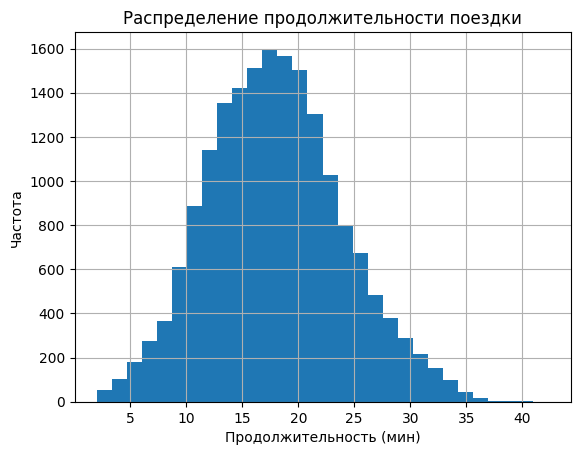

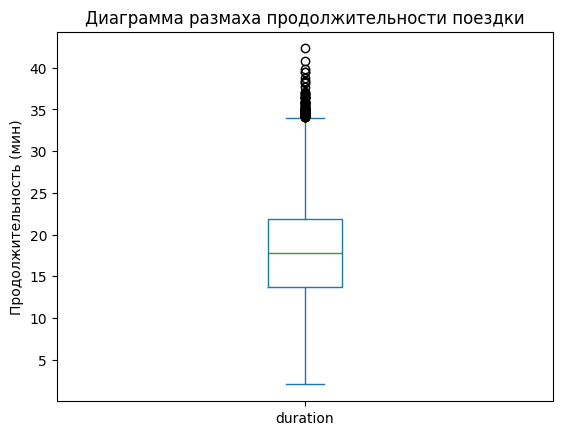

count    18068.000000
mean        17.960088
std          6.030008
min          2.035632
25%         13.697117
50%         17.750643
75%         21.824361
max         42.299772
Name: duration, dtype: float64

In [14]:
df_rides.loc[df_rides['duration']<2, 'duration'] = None
df_rides.loc[df_rides['duration'].isna(), 'duration'] = (df_rides['duration']/df_rides['distance']).median()*df_rides['distance']

df_rides['duration'].hist(bins=30)
plt.title('Распределение продолжительности поездки')
plt.xlabel('Продолжительность (мин)')
plt.ylabel('Частота')
plt.show()
df_rides['duration'].plot(kind='box')
plt.title('Диаграмма размаха продолжительности поездки')
plt.xlabel('')
plt.ylabel('Продолжительность (мин)')
plt.show()
df_rides['duration'].describe()

### Объединение данных и дополнительный анализ

#### Объединение данных

Объединим три датасета в один и убедимся, что размер остался прежним:

In [15]:
df = df_users.merge(df_rides, on='user_id').merge(df_subs, on='subscription_type')
print(f'Размер до: {len(df_rides)}, размер после: {len(df)}')
df

Размер до: 18068, размер после: 18068


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


#### Дополнительный анализ

Для начала создадим также отдельные наборы данных для пользователей с подпиской и без неё:

In [16]:
df_sub = df[df['subscription_type']=='ultra']
df_free = df[df['subscription_type']=='free']

Построим распределение расстояния и диаграмму размаха для пользователей с подпиской и без неё. Видно, что для пользователей без подписки оно в среднем и медианно ниже, а само распределение имеет большую дисперсию, более длинный хвост справа и больший второй пик в зоне малых расстояний (до 1500 м):

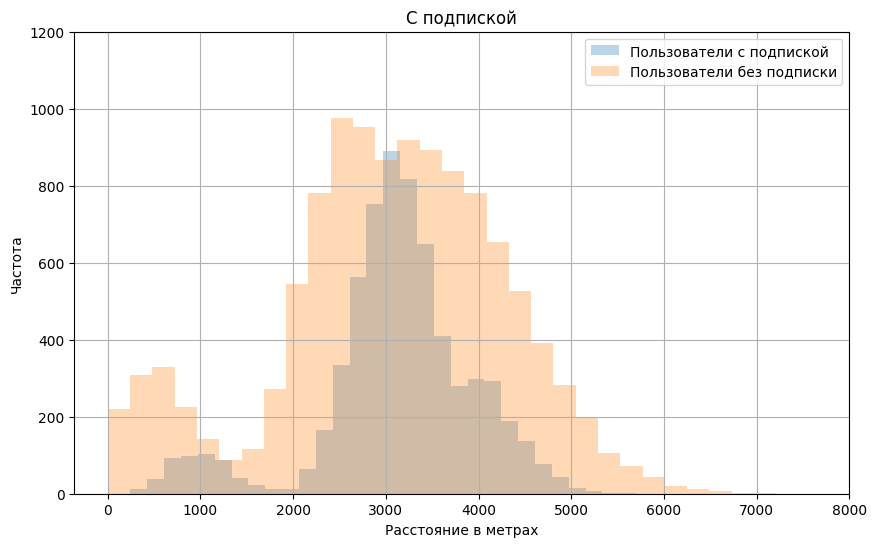

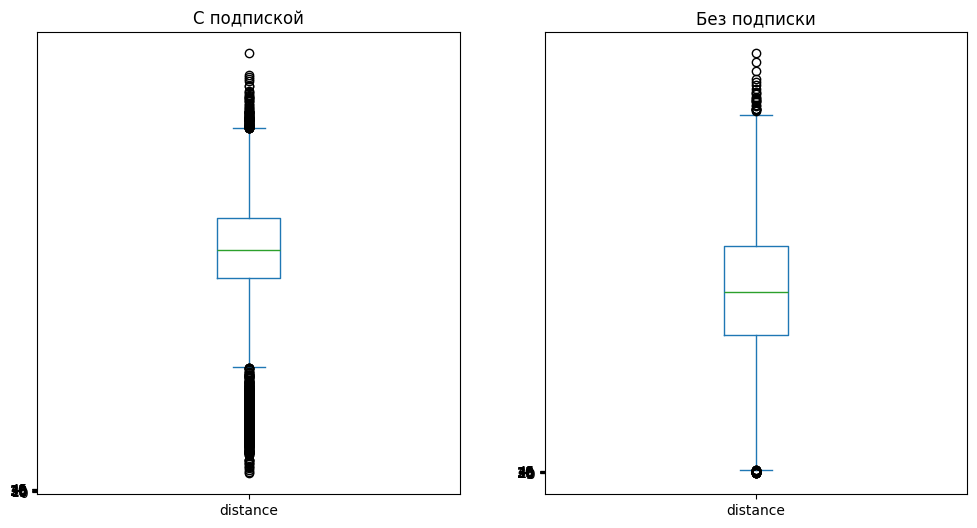

,С подпиской,Без подписки
count,6500.000000,11568.000000
mean,3115.445388,3045.495282
std,836.895330,1246.173806
min,244.210438,0.855683
25%,2785.444017,2366.562689
50%,3148.637229,3114.648465
75%,3560.574425,3905.697894
max,5699.769662,7211.007745


In [17]:
plt.figure(figsize=(10,6))
df_sub['distance'].hist(bins=30, alpha=0.3)
df_free['distance'].hist(bins=30, alpha=0.3)
plt.xticks(range(0, 9000, 1000))
plt.yticks(range(0, 1400, 200))
plt.title('С подпиской')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Частота')
plt.legend(['Пользователи с подпиской', 'Пользователи без подписки'])
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax1, ax2 = axes
df_sub['distance'].plot(kind='box', ax=ax1)
df_free['distance'].plot(kind='box', ax=ax2)
ax1.set_yticks(range(0, 50, 5)), ax2.set_yticks(range(0, 50, 5))
ax1.set_title('С подпиской'), ax2.set_title('Без подписки')
plt.show()
pd.concat([df_sub['distance'].describe().rename('С подпиской'), df_free['distance'].describe().rename('Без подписки')], axis=1)

Построим распределение длительности поездки и диаграмму размаха для пользователей с подпиской и без неё. Видно, что для пользователей без подписки она в среднем и медианно ниже, а само распределение имеет большую дисперсию, более короткий хвост справа и небольшой второй пик в зоне длительности, почти равной нулю:

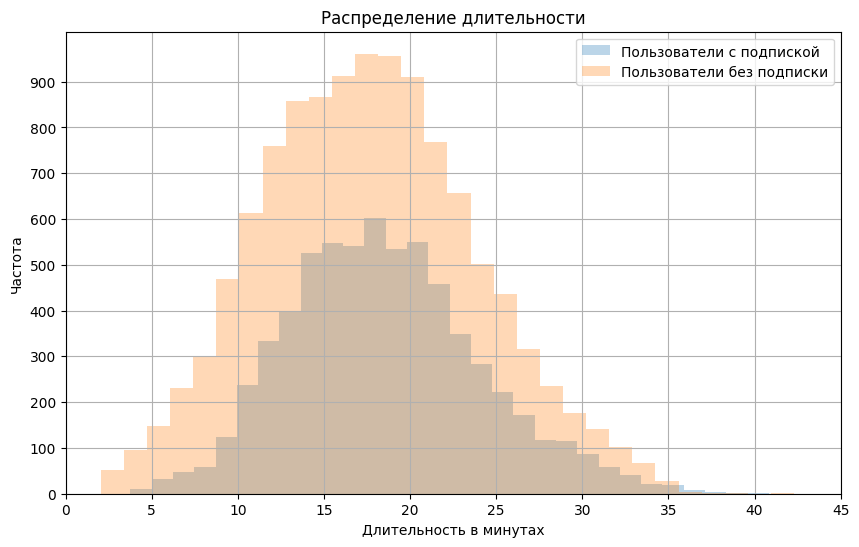

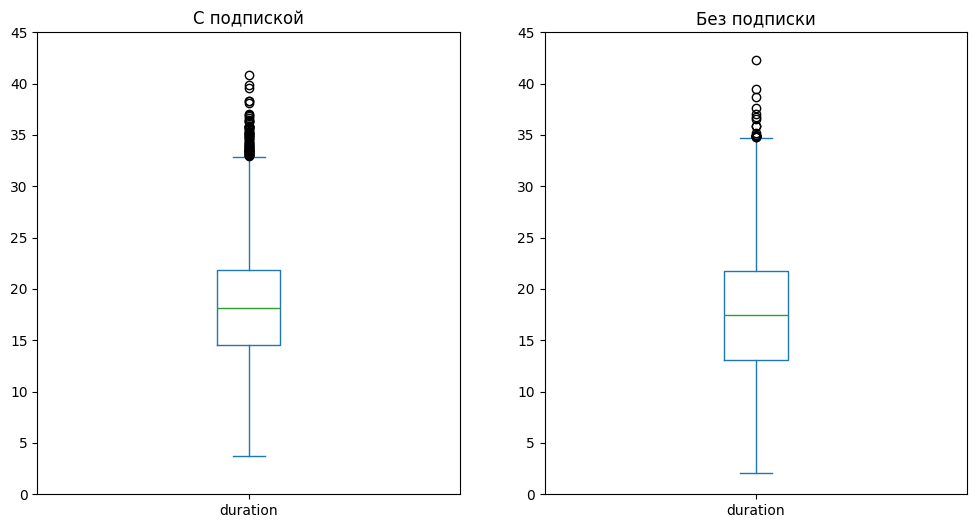

,С подпиской,Без подписки
count,6500.000000,11568.000000
mean,18.541985,17.633122
std,5.572048,6.249180
min,3.760353,2.035632
25%,14.524654,13.127082
50%,18.178153,17.446822
75%,21.884129,21.779484
max,40.823963,42.299772


In [18]:
plt.figure(figsize=(10,6))
df_sub['duration'].hist(bins=30, alpha=0.3)
df_free['duration'].hist(bins=30, alpha=0.3)
plt.xticks(range(0, 50, 5))
plt.yticks(range(0, 1000, 100))
plt.title('Распределение длительности')
plt.xlabel('Длительность в минутах')
plt.ylabel('Частота')
plt.legend(['Пользователи с подпиской', 'Пользователи без подписки'])
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax1, ax2 = axes
df_sub['duration'].plot(kind='box', ax=ax1)
df_free['duration'].plot(kind='box', ax=ax2)
ax1.set_yticks(range(0, 50, 5)), ax2.set_yticks(range(0, 50, 5))
ax1.set_title('С подпиской'), ax2.set_title('Без подписки')
plt.show()
pd.concat([df_sub['duration'].describe().rename('С подпиской'), df_free['duration'].describe().rename('Без подписки')], axis=1)

### Подсчёт выручки

Создадим датафрейм с агрегированными данными о поездках, посчитав суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. Добавим в этот набор данных и помесячную выручку, которую принёс каждый пользователь:

In [19]:
print(df.set_index(['user_id', 'month'])[['minute_price', 'start_ride_price', 'subscription_type']])
df_pt = (df
         .assign(duration=np.ceil(df['duration']).astype('int'))
         .pivot_table(index=['user_id', 'month'], values=['date', 'distance', 'duration'], 
                      aggfunc={'distance':'sum', 'duration':'sum', 'date':'count'})
         .rename(columns={'date':'number'})
         .reset_index()
         .merge(df_users[['user_id', 'subscription_type']], on='user_id', how='left')
         .merge(df_subs, on='subscription_type', how='left')
         .set_index(['user_id', 'month'])
        )
df_pt['distance'] = round(df_pt['distance']).astype('int')
df_pt['revenu'] = df_pt['subscription_fee']+df_pt['minute_price']*df_pt['duration']+df_pt['number']*df_pt['start_ride_price']
df_pt.drop(['subscription_fee', 'minute_price', 'start_ride_price'], axis=1, inplace=True)
df_pt

               minute_price  start_ride_price subscription_type
user_id month                                                  
1       1                 6                 0             ultra
        1                 6                 0             ultra
        4                 6                 0             ultra
        8                 6                 0             ultra
        8                 6                 0             ultra
...                     ...               ...               ...
1534    11                8                50              free
        11                8                50              free
        11                8                50              free
        11                8                50              free
        12                8                50              free

[18068 rows x 3 columns]


number  distance  duration subscription_type  revenu
user_id month                                                      
1       1           2      7028        42             ultra     451
        4           1       754         7             ultra     241
        8           2      6723        46             ultra     475
        10          2      5810        32             ultra     391
        11          3      7003        56             ultra     535
...               ...       ...       ...               ...     ...
1534    6           2      3409        26              free     308
        8           2      7622        48              free     484
        9           1      4928        23              free     234
        11          4     13350        78              free     824
        12          1      2372        16              free     178

[11331 rows x 5 columns]

### Проверка гипотез

Проверим несколько гипотез для сравнения пользователей с подпиской и без неё.

#### Средняя продолжительность поездки

Проверим нулевую гипотезу о том, что средняя продолжительность поездки для пользователей с подпиской равна таковой у пользователей без подписки. Альтернативная гипотеза - средняя продолжительность поездки для пользователей с подпиской выше. Как видно, нулевую гипотезу удалось отвергнуть:

In [20]:
alpha = 0.05
_, p_val = st.ttest_ind(df_sub['duration'], df_free['duration'], alternative='greater')
print(f'{p_val:.2e}', p_val<alpha, round(df_sub['duration'].mean(), 1), round(df_free['duration'].mean(), 1))

1.06e-22 True 18.5 17.6


Итак, согласно результатам теста пользователи с подпиской действительно в среднем тратят больше времени на поездки (18.5 минут против 17.6).

#### Среднее расстояние

Проверим нулевую гипотезу о том, что среднее расстояние поездки у пользователей с подпиской равно 3130. Альтернативная гипотеза - среднее расстояние выше. Как видно, нулевую гипотезу не удалось отвергнуть:

In [21]:
alpha = 0.05
optimal_value = 3130
_, p_val = st.ttest_1samp(df_sub['distance'], optimal_value, alternative='greater')
print(f'P-значение: {round(p_val, 3)}')
print(f'Проверка на соответствие порогу: {p_val<alpha}')
print(f'Среднее расстояние для пользователей с подпиской: {round(df_sub["distance"].mean())}')

P-значение: 0.92
Проверка на соответствие порогу: False
Среднее расстояние для пользователей с подпиской: 3115


Итак, по результатам проведённого теста нет оснований предполагать, что пользователи с подпиской в среднем проехжают большее расстояние, чем пользователи без подписки.

#### Помесячная выручка

Проверим нулевую гипотезу о том, что помесячная выручка от пользователей с подпиской по месяцам равна таковой от пользователей без подписки. Альтернативная гипотеза - помесячная выручка от пользователей с подпиской выше. Как видно, нулевую гипотезу удалось отвергнуть:

In [22]:
alpha = 0.05
_, p_val = st.ttest_ind(df_pt[df_pt.index.get_level_values(0).isin(df_sub['user_id'])]['revenu'], 
                        df_pt[df_pt.index.get_level_values(0).isin(df_free['user_id'])]['revenu'], 
                        alternative='greater')
print(f'{p_val:.2e}', p_val<alpha, 
      round(df_pt.loc[df_pt['subscription_type']=='ultra']['revenu'].mean(), 2), 
      round(df_pt.loc[df_pt['subscription_type']=='free']['revenu'].mean(), 2))

9.69e-26 True 362.79 331.94


Итак, согласно результатам теста средняя помесячная выручка от пользователей с подпиской действительно выше, чем от остальных пользователей (362.79 рублей против 331.94).

#### Дополнительное задание

**Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?**

В такой ситуации пригодился бы односторонний тест Стьюдента для зависимых выборок, проверяющий нулевую гипотезу о том, что среднее количество обращений до обновления было больше; это выглядело бы примерно так: `st.ttest_rel(before, after, alternative=greater)`

### Распределения

#### Дополнительное задание

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.  
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Наивной реализацией двоичного поиска найдём минимальное количество разосланных промокодов n, при котором вероятность не выполнить план в 100 клиентов не превысит 5%. Для полученного значения 1172 построим биномиальное распределение:

Границы поиска и вероятность на каждой итерации:
1000 2000 0.0
1000 1500 0.009
1000 1250 0.115
1126 1250 0.036
1126 1188 0.066
1158 1188 0.049
1158 1173 0.057
1166 1173 0.053
1170 1173 0.051
1172 1173 0.05

Найденное оптимальное значение: 1172
Полученная вероятность не выполнить план равна 4.955%


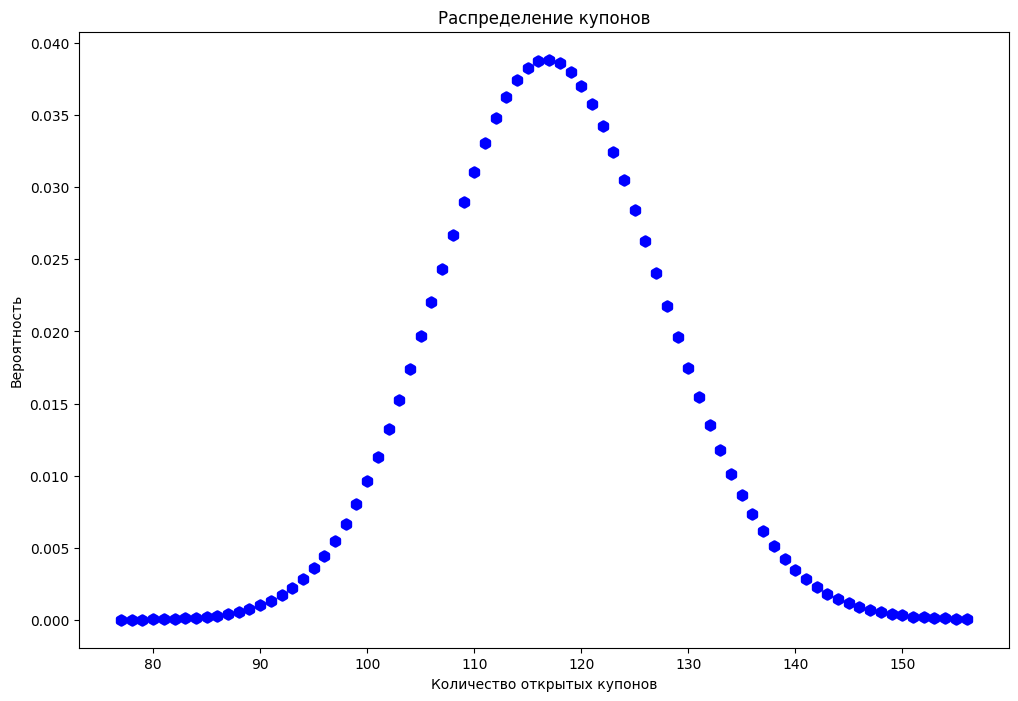

In [23]:
thresh = 100
n_min = 1000
n_max = 2000
p = 0.1
target = 0.05

print('Границы поиска и вероятность на каждой итерации:')
while n_min < n_max: 
        n_mid = (n_max + n_min) // 2
        p_mid = st.binom.cdf(thresh, n_mid, p)
        print(n_min, n_max, round(p_mid, 3))
        if p_mid<=target:
            n_max = n_mid
        elif p_mid>target:
            n_min = n_mid + 1
n = n_min
print(f'\nНайденное оптимальное значение: {n}')
print(f'Полученная вероятность не выполнить план равна {100*round(st.binom.cdf(thresh, n, p), 5)}%')

E = round(n*p)
std = round(sqrt(n*p*(1-p)))
x = range(E-4*std, E+4*std)
y = st.binom.pmf(x, n, p)

plt.figure(figsize=(12, 8))
plt.scatter(x, y, marker='h', c='b', lw=3)
plt.title('Распределение купонов')
plt.xlabel('Количество открытых купонов')
plt.ylabel('Вероятность')
plt.show()

#### Дополнительное задание

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 %40 % получивших клиентов. Отдел планирует разослать 11 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5399,5 тыс. пользователей.

При таком большом n и близком к 0.5 p можно аппроксимировать биномиальное распределение нормальным. Найденные параметры матожидания 40000 и стандартного отклонения 490 показывают, что матожидание отстоит и от 0, и от n намного более, чем на необходимые для аппроксимации 3 стандартных отклонения. Построим график распределения в пределах 4 стандартных отклонений в обе стороны от матожидания и найдём искомую вероятность:

Матожидание равно 400000, стандартное отклонение равно 489.90


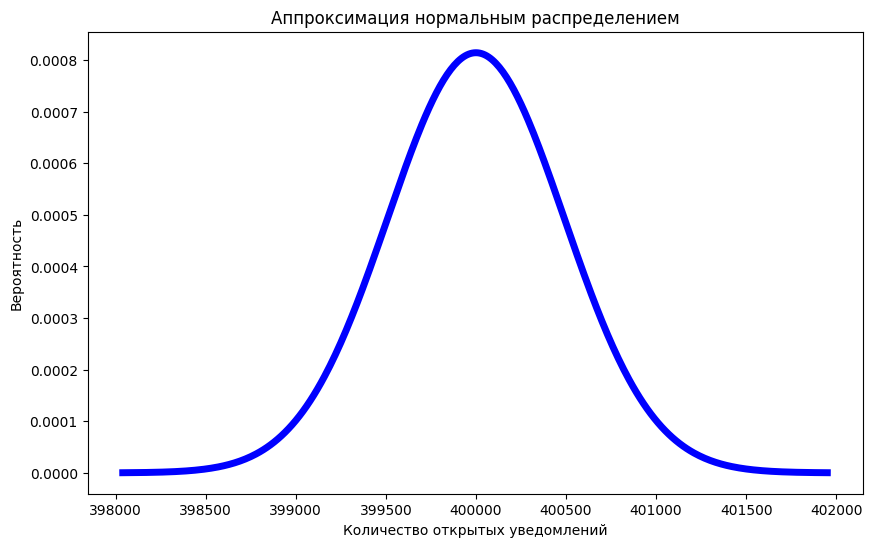

Искомая вероятность без аппроксимации: 15.40%
Искомая вероятность с аппроксимацией: 15.37%


In [24]:
n = 10**6
p = 0.4
thresh = 399500

mu = n*p
sigma = sqrt(n*p*(1-p))
left, right = round(mu-4*sigma), round(mu+4*sigma)
print(f'Матожидание равно {mu:.0f}, стандартное отклонение равно {sigma:.2f}')

x = range(left, right, 10)
y = st.norm.pdf(x, mu, sigma)
plt.figure(figsize=(10, 6))
plt.plot(x, y, '-b', lw=5)
plt.title('Аппроксимация нормальным распределением')
plt.xlabel('Количество открытых уведомлений')
plt.ylabel('Вероятность')
plt.show()

print(f'Искомая вероятность без аппроксимации: {100*st.binom.cdf(thresh, n, p):.2f}%')
print(f'Искомая вероятность с аппроксимацией: {100*st.norm.cdf(thresh, mu, sigma):.2f}%')

# Вывод

1. В рамках проекта по аналитике для сервиса аренды самокатов GoFast велась работа с тремя датасетами, в которых содержалась информация о пользователях, их поездках и подписках. Была считана информация о 1565 пользователях, 18068 поездках и двух типах статуса подписки (с подпиской и без; для пользователей с подпиской старт поездки бесплатный и стоимость минуты меньше, но есть абонентская плата). Пропусков в данных не было.

2. Произведена предобработка данных:
- столбец с датой поездки приобразован к типу datetime
- создан отдельный столбец с месяцем поездки
- явные дубликаты пользователей в количестве 31 были удалены, неявные дубликаты отсутствовали

3. В рамках исследовательского анализа данных описаны:
- частота встречаемости городов (данные примерно поровну распределены среди 8 крупных городов)
- соотношение пользователей с подпиской и без подписки (45.4% на 54.6%)
- возраст пользователей (от 12 до 43 лет, медиана и среднее на уровне 25 лет, распределение схоже с нормальным)
- расстояние, которое пользователь преодолел за одну поездку (от 1 до 7211 метра со средним 3070 и медианой 3130, распределение отличается от нормального из-за малого пика в районе 500 метров)
- продолжительность поездок (для 95 аномальных поездок продолжительность была рассчитана на основании медианы соотношения продолжительности и расстояния; в итоге получено распределение от 2 до 43.2 минут, среднее и медиана находятся в районе 18 минут, распределение схоже с нормальным)

4. Проведено объединение данных:
- данные из трёх датасетов объединены в один
- дополнительно из предыдущего датасета созданы два набора данных для пользователей с подпиской и без неё
- из построенных графиков и таблиц сделан вывод о том, что средняя длительность поездок для пользователей с подпиской немного выше, чем без подписки (18.5 минут против 17.6), аналогично для расстояния (3115 метров против 3045)

5. Рассчитаны дополнительные агрегированные данные (в отдельном датасете):
- суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц
- помесячная выручка, которую принёс каждый пользователь

6. На уровне значимости 5% проверены следующие гипотезы:
- 1) Средняя продолжительность поездки для пользователей с подпиской равна таковой у пользователей без подписки. Альтернативная гипотеза - средняя продолжительность поездки для пользователей с подпиской выше. **Результат:** нулевую гипотезу удалось отвергнуть.
- 2) Среднее расстояние поездки у пользователей с подпиской равно 3130. Альтернативная гипотеза - среднее расстояние выше. **Результат:** нулевую гипотезу не удалось отвергнуть.
- 3) Средняя помесячная выручка от пользователей с подпиской по месяцам равна таковой от пользователей без подписки. Альтернативная гипотеза - помесячная выручка от пользователей с подпиской выше. **Результат:** нулевую гипотезу удалось отвергнуть.